In [1]:
! gdown https://drive.google.com/u/3/uc?id=1-52ga1hIGY-_2cIaS-gRmWkt14BJOxO9

Downloading...
From: https://drive.google.com/u/3/uc?id=1-52ga1hIGY-_2cIaS-gRmWkt14BJOxO9
To: /content/jimutmap_less.zip
926MB [00:08, 114MB/s]


In [2]:
! unzip -qq jimutmap_less.zip

In [15]:
#! unzip -qq roads.zip
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from tensorflow.keras.metrics import Recall, Precision 
from tensorflow.keras import backend as K


In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [25]:
np.random.seed(42)
tf.random.set_seed(42)

## Hyperparameters

IMG_SIZE = 256
EPOCHS = 10
BATCH = 2
LR = 1e-5


PATH = ''

In [127]:
import glob
images_list = sorted(glob.glob("jimutmap_less/map/*"))
masks_list = sorted(glob.glob("jimutmap_less/roads/*"))
print(images_list[:10])
print(len(images_list))
print(len(masks_list))
print(masks_list[:10])

['jimutmap_less/map/391102_228090.jpeg', 'jimutmap_less/map/391102_228091.jpeg', 'jimutmap_less/map/391102_228172.jpeg', 'jimutmap_less/map/391102_228240.jpeg', 'jimutmap_less/map/391102_228255.jpeg', 'jimutmap_less/map/391102_228259.jpeg', 'jimutmap_less/map/391102_228260.jpeg', 'jimutmap_less/map/391102_228263.jpeg', 'jimutmap_less/map/391102_228427.jpeg', 'jimutmap_less/map/391102_228431.jpeg']
3098
3098
['jimutmap_less/roads/391102_228090_road.png', 'jimutmap_less/roads/391102_228091_road.png', 'jimutmap_less/roads/391102_228172_road.png', 'jimutmap_less/roads/391102_228240_road.png', 'jimutmap_less/roads/391102_228255_road.png', 'jimutmap_less/roads/391102_228259_road.png', 'jimutmap_less/roads/391102_228260_road.png', 'jimutmap_less/roads/391102_228263_road.png', 'jimutmap_less/roads/391102_228427_road.png', 'jimutmap_less/roads/391102_228431_road.png']


In [118]:
print(len(images_list) - len(images_list)*0.05)

58852.5


In [126]:
#! rm -rf jimutmap_less/roads/390303_227867_road.png

In [123]:
import os
from tqdm import tqdm

for img_fl in tqdm(images_list[:58852]):
  try:
    os.remove(img_fl)
    #print(img_fl)
    mask_name = "jimutmap_less/roads/"+str(img_fl.split('.')[0]).split('/')[-1]+"_road.png"
    os.remove(mask_name)
    #break
  except:
    pass


100%|██████████| 58852/58852 [00:03<00:00, 18014.90it/s]


NameError: ignored

In [146]:
from glob import glob
def load_data(path, split=0.1):

  images_list = sorted(glob(os.path.join(path, "jimutmap_less/map/*")))
  masks_list = sorted(glob(os.path.join(path, "jimutmap_less/roads/*")))

  tot_size = len(images_list)
  val_size = int(split * tot_size)
  test_size = int(split * tot_size)

  x_train, x_val = train_test_split(images_list, test_size=val_size, random_state=42)
  y_train, y_val = train_test_split(masks_list, test_size=val_size, random_state=42)
  x_train, x_test = train_test_split(x_train, test_size=test_size, random_state=42)
  y_train, y_test = train_test_split(y_train, test_size=test_size, random_state=42)

  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [147]:

def read_img(path):
    path = path.decode()
    tmp = cv2.imread(path, cv2.IMREAD_COLOR)
    tmp = cv2.resize(tmp, (IMG_SIZE, IMG_SIZE))
    tmp = tmp/255.0
    return tmp



def read_mask(path):
    path = path.decode()
    tmp = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    tmp = cv2.resize(tmp, (IMG_SIZE, IMG_SIZE))
    tmp = tmp/255.0
    tmp = np.expand_dims(tmp, axis=-1)
    return tmp


In [148]:
def tf_parse(a, b):
    def _parse(a, b):
        a = read_img(a)
        b = read_mask(b)
        return a, b

    a, b = tf.numpy_function(_parse, [a, b], [tf.float64, tf.float64])
    a.set_shape([IMG_SIZE, IMG_SIZE, 3])
    b.set_shape([IMG_SIZE, IMG_SIZE, 1])
    return a, b

def tf_dataset(a, b, batch=32):
    data = tf.data.Dataset.from_tensor_slices((a, b))
    data = data.map(tf_parse)
    data = data.batch(batch)
    data = data.repeat()
    return data

In [149]:

(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data("")

print("Training data: ", len(x_train))
print("Validation data: ", len(x_val))
print("Testing data: ", len(x_test))

Training data:  2480
Validation data:  309
Testing data:  309


In [150]:
def read_and_rgb(a):
    a = cv2.imread(a)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

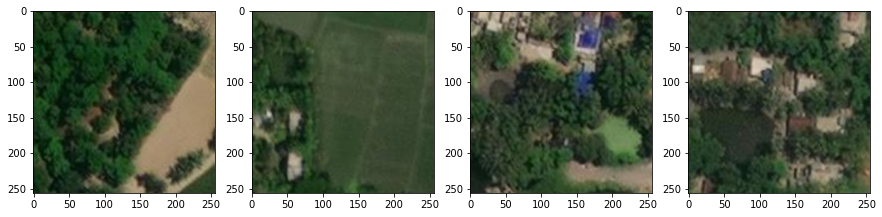

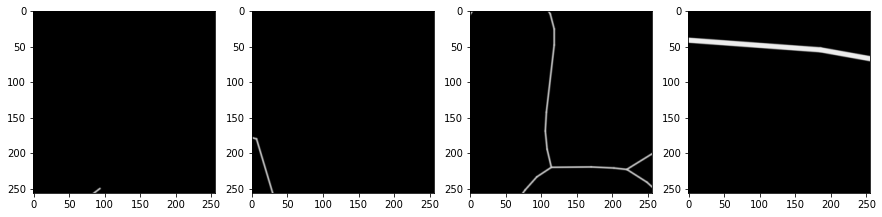

In [151]:
fig = plt.figure(figsize=(15, 15))
x = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(x_train[0]))

x = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(x_train[1]))
imgplot.set_clim(0.0, 0.7)

x = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(x_train[2]))
imgplot.set_clim(0.0, 1.4)

x = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(x_train[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
x = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(y_train[0]))

x = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(y_train[1]))
imgplot.set_clim(0.0, 0.7)

x = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(y_train[2]))
imgplot.set_clim(0.0, 1.4)

x = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(y_train[3]))
imgplot.set_clim(0.0, 1.4)

In [152]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [153]:
model = MultiResUnet(height=256, width=256, n_channels=3)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_176 (Conv2D)             (None, 256, 256, 8)  216         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_260 (BatchN (None, 256, 256, 8)  24          conv2d_176[0][0]                 
__________________________________________________________________________________________________
activation_174 (Activation)     (None, 256, 256, 8)  0           batch_normalization_260[0][0]    
_______________________________________________________________________________________

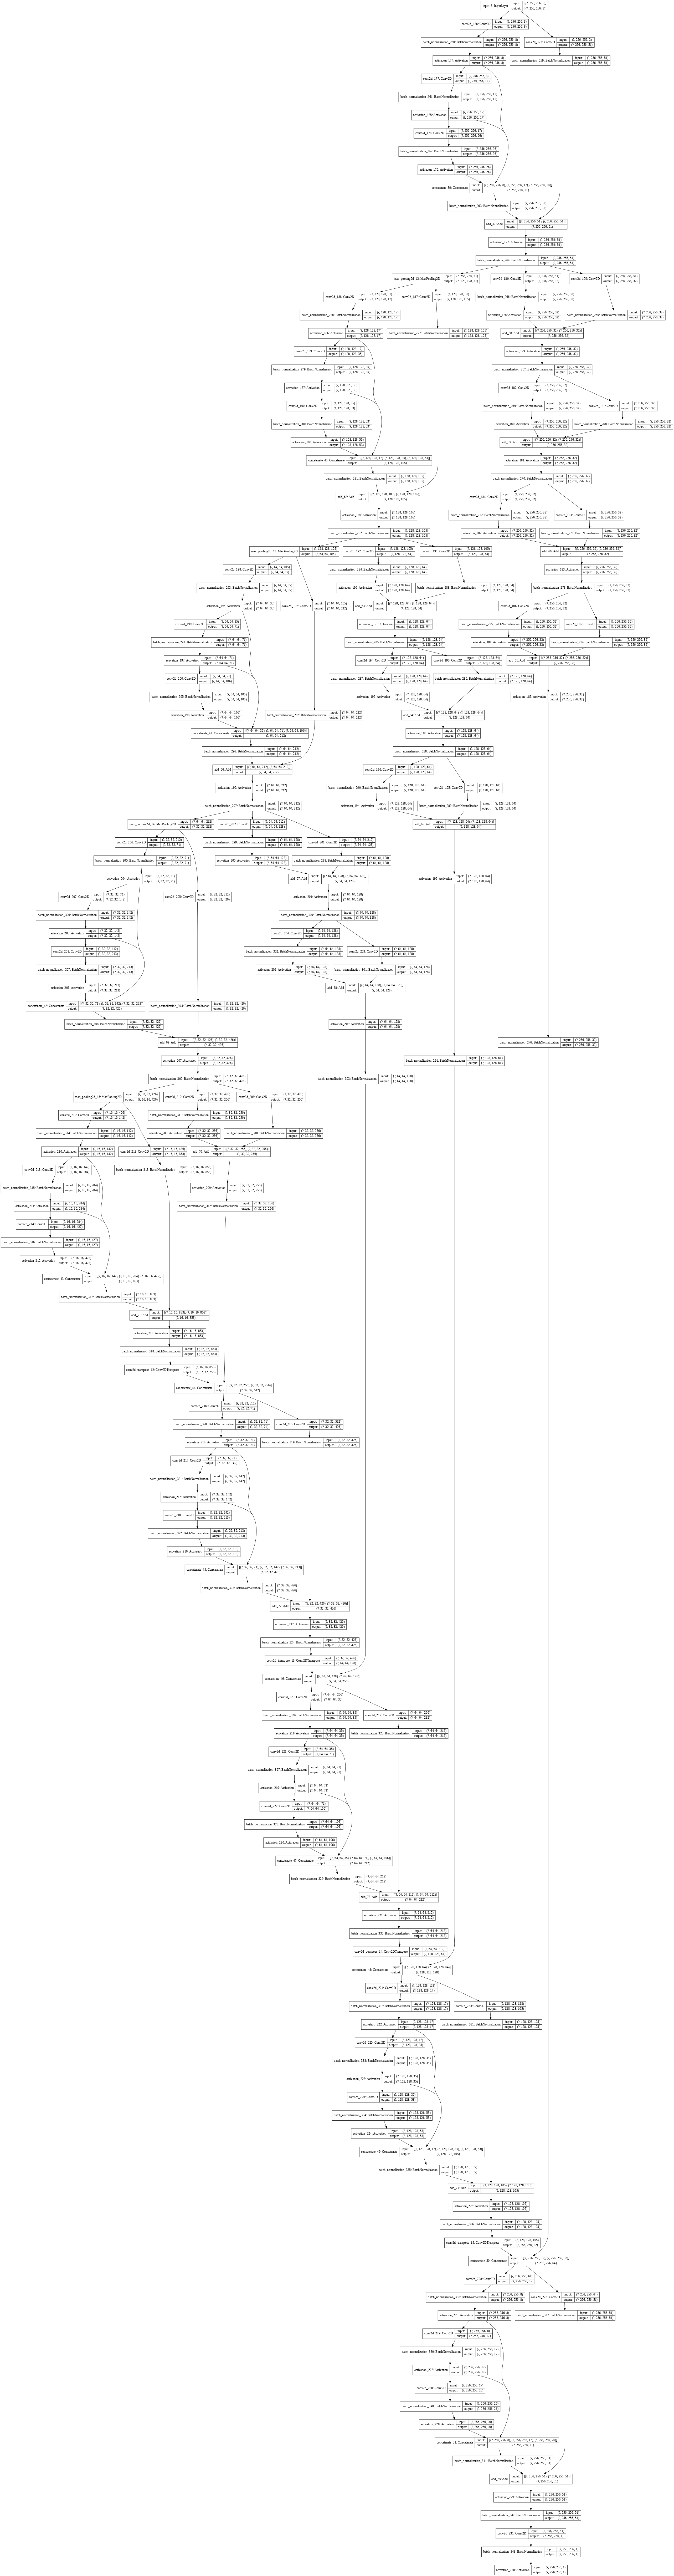

In [154]:
from tensorflow.keras.utils import  plot_model as pm  #plotting the model structure
pm(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

In [155]:
#from keras import backend as K 

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def jacard(y_true, y_pred):

    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum ( y_true_f * y_pred_f)
    union = tf.reduce_sum( y_true_f + y_pred_f - y_true_f * y_pred_f)
    return (intersection/union)

In [156]:
train_data = tf_dataset(x_train, y_train, batch=BATCH)
valid_data = tf_dataset(x_val, y_val, batch=BATCH)

In [157]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision(), jacard, 'accuracy']
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [158]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ModelCheckpoint("./model_checkpoint", monitor='val_loss'),
    keras.callbacks.TensorBoard(log_dir=logdir)
]

In [159]:
train_steps = len(x_train)//BATCH
valid_steps = len(x_val)//BATCH

if len(x_train) % BATCH != 0:
    train_steps += 1
if len(x_val) % BATCH != 0:
    valid_steps += 1

In [161]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/4
1240/1240 [==============================] - ETA: 0s - loss: 0.9766 - dice_coef: 0.0234 - recall_15: 0.5916 - precision_15: 0.0265 - jacard: 0.0119 - accuracy: 0.5614WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
1240/1240 [==============================] - 220s 177ms/step - loss: 0.9766 - dice_coef: 0.0234 - recall_15: 0.5916 - precision_15: 0.0265 - jacard: 0.0119 - accuracy: 0.5614 - val_loss: 0.9725 - val_dice_coef: 0.0274 - val_recall_15: 0.6210 - val_precision_15: 0.0359 - val_jacard: 0.0140 -

In [163]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)



# save to json:
hist_json_file = 'history.json'
# with open(hist_json_file, 'a') as out:
#     out.write(hist_df.to_json())
#     out.write(",")
#     out.close()

with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv:
hist_csv_file = 'history.csv'
# with open(hist_csv_file, 'a') as out:
#     out.write(str(hist_df.to_csv()))
#     out.write(",")
#     out.close()


with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


In [176]:
model.save_weights("MultiResUNET_jimutmap_2_10e.h5")
model.save("MultiResUNET_jimutmap_with_weight_2_10e.h5")


In [179]:
test_data = tf_dataset(x_test, y_test, batch=BATCH)

test_steps = (len(x_test)//BATCH)
if len(x_test) % BATCH != 0:
    test_steps += 1

model.evaluate(test_data, steps=test_steps)



155/155 [==============================] - 5s 34ms/step - loss: 0.9745 - dice_coef: 0.0255 - recall_15: 0.4304 - precision_15: 0.0487 - jacard: 0.0130 - accuracy: 0.8182


[0.9744724631309509,
 0.025487057864665985,
 0.43042370676994324,
 0.04865207150578499,
 0.01297297328710556,
 0.8181735873222351]

In [180]:
def read_img(path):
    xt = cv2.imread(path, cv2.IMREAD_COLOR)
    xt = cv2.cvtColor(xt, cv2.COLOR_BGR2RGB)
    xt = cv2.resize(xt, (IMG_SIZE, IMG_SIZE))
    xt = xt/255.0
    return xt

def read_mask(path):
    xt = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    xt = cv2.resize(xt, (IMG_SIZE, IMG_SIZE))
    xt = np.expand_dims(xt, axis=-1)
    xt = xt/255.0
    return xt

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [189]:
for i, (a, b) in enumerate(zip(x_test[10:30], y_test[10:30])):
    a = read_img(a)
    b = read_mask(b)
    y_pred = model.predict(np.expand_dims(a, axis=0))[0] > 0.5
    #print(y_pred.shape)
    h, w, _ = a.shape
    white_line = np.ones((h, 10, 3))
    mask_red = np.ones((h,w,3))
    # mask_red[:,:,0] = a[:,:,0]*.5
    # mask_red[:,:,1] = a[:,:,1]*0.5 
    mask_red[:,:,:] = y_pred[:,:,:] #+ a[:,:,2]*0.5  
    mask_red = mask_red*2
    mask_red = np.clip(mask_red, 0, 1)
    all_images = [
        a, white_line,
        mask_parse(b), white_line,
        mask_red
        #mask_parse(y_pred)*0.5+a*0.5
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    x = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)

    plt.savefig('results/'+str(i)+'.png',format='png')
    plt.close()


In [164]:
import json

with open('history.json', 'r') as f:
    array = json.load(f)
print (array)

{'loss': {'0': 0.9765633941, '1': 0.9732347131, '2': 0.9701958299, '3': 0.9666028619}, 'dice_coef': {'0': 0.0234364718, '1': 0.0267656147, '2': 0.0298043713, '3': 0.0333977267}, 'recall_15': {'0': 0.5915877223, '1': 0.6712372899, '2': 0.7295556068, '3': 0.7985694408}, 'precision_15': {'0': 0.0265243389, '1': 0.0335787162, '2': 0.0413566194, '3': 0.0532866903}, 'jacard': {'0': 0.0119069703, '1': 0.0136333574, '2': 0.0152170165, '3': 0.0170967765}, 'accuracy': {'0': 0.5613587499, '1': 0.6075795293, '2': 0.6540801525, '3': 0.7066764235}, 'val_loss': {'0': 0.9725314975, '1': 0.9710496664, '2': 0.9721149206, '3': 0.9737849832}, 'val_dice_coef': {'0': 0.0274280738, '1': 0.0289066993, '2': 0.0278357901, '3': 0.0261660293}, 'val_recall_15': {'0': 0.6209507585, '1': 0.5704245567, '2': 0.5013914108, '3': 0.4233542979}, 'val_precision_15': {'0': 0.035870295, '1': 0.0450842232, '2': 0.0489210375, '3': 0.0472678952}, 'val_jacard': {'0': 0.0139729641, '1': 0.0147450138, '2': 0.0141875148, '3': 0.013

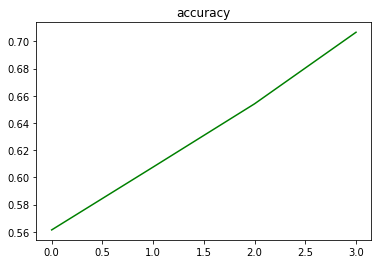

In [165]:
accuracy = []
for item in array['accuracy']:
  accuracy.append(array['accuracy'][item])
#print(accuracy)
plt.title('accuracy')
plt.plot(accuracy,color='green')

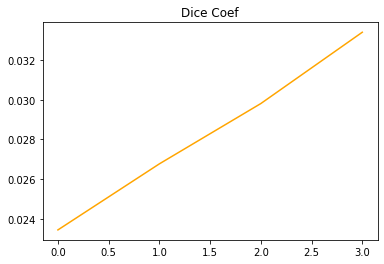

In [166]:
dice_coef = []
for item in array['dice_coef']:
  dice_coef.append(array['dice_coef'][item])
#print(dice_coef)
plt.title('Dice Coef')
plt.plot(dice_coef,color='orange')

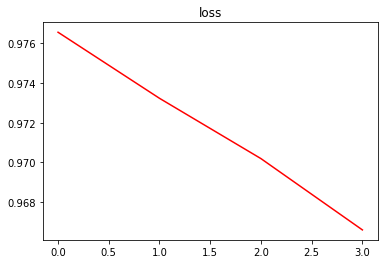

In [167]:
loss = []
for item in array['loss']:
  loss.append(array['loss'][item])
#print(loss)
plt.title('loss')
plt.plot(loss,color='red')

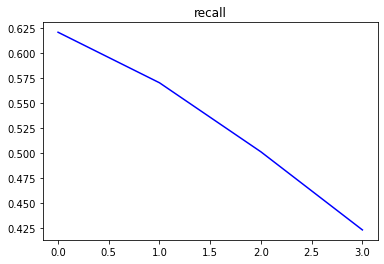

In [171]:
recall = []
for item in array['val_recall_15']:
  recall.append(array['val_recall_15'][item])
#print(recall)
plt.title('recall')
plt.plot(recall,color='blue')

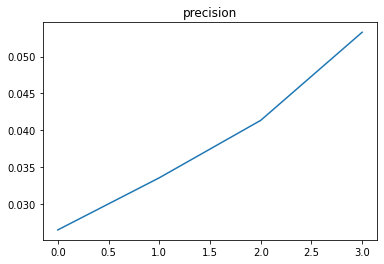

In [172]:
precision = []
for item in array['precision_15']:
  precision.append(array['precision_15'][item])
#print(precision)
plt.title('precision')
plt.plot(precision)